In [58]:
import pandas as pd
import numpy as np
import random
import math
import gc
import matplotlib.pylab as plt
import networkx as nx
from random import sample
from time import time

#Graph Generator

In [59]:
def generate_graph(v, e, unconnected):
	for i in range(100): # prevent infinite loop
		edges = []
		for i in range(e):
			conflict = True
			while (conflict):
				edge = sample([j for j in range(v - unconnected)], 2)
				if (min(edge), max(edge)) not in edges:
					conflict = False
					edges.append((min(edge), max(edge)))
		edges = sorted(edges, key=lambda row: (row[0], row[1]))
		flat_list = [i for edge in edges for i in edge]

		for i in range(v - unconnected):
			if i not in flat_list:
				break
		else:
			return edges
	return None # unable to fulfill the condition

#Graph Configuration

In [60]:
nodes = int(input("number of vertices: "))
edges_cnt = int(input("number of edges: "))
unconnect = input("number of unconnected: ")
try:
	unconnect = int(unconnect)
except:
	unconnect = 0
edges = generate_graph(nodes, edges_cnt, unconnect)
if edges == None:
	raise SystemExit("Unable to generate graph.\nPlease change the parameter")
edges_cnt = len(edges)

#Exact Method Configuration

In [61]:
def isCover(V, k, E):
	Set = (1 << k) - 1
	limit = (1 << V)
	vis = [[None] * V for i in range(V)]
	while (Set < limit):
		vis = [[0] * V for i in range(V)]
		cnt = 0
		j = 1
		v = 1
		while(j < limit):
			if (Set & j and v < V and k < V):
				for k in range(0, V):
					if (gr[v][k] and not vis[v][k]):
						vis[v][k] = 1
						vis[k][v] = 1
						cnt += 1
			j = j << 1
			v += 1
		if (cnt == E):
			return True
		c = Set & -Set
		r = Set + c
		Set = (((r ^ Set) >> 2) // c) | r
	return False

In [62]:
def findMinCover(n, m):
	left = 1
	right = n
	while (right > left):
		mid = (left + right) >> 1
		if (isCover(n, mid, m) == False):
			left = mid + 1
		else:
			right = mid
	return left

In [63]:
def insertEdge(u, v):
	gr[u][v] = 1
	gr[v][u] = 1

gr = [[None] * nodes for i in range(nodes)]

for x, y in edges:
	insertEdge(x, y)

#Non-Exact Method Configuration

In [64]:
adjacency_matrix = np.zeros((nodes,nodes),dtype = np.int)
adjacency_matrix.shape

(20, 20)

In [65]:
for i, j in edges:
	adjacency_matrix[i, j] = 1

In [66]:
# print(edges)
print("Number of edges {}".format(edges_cnt))

Number of edges 30


In [67]:
G=nx.Graph()
G.add_nodes_from(list(range(0,nodes)))
G.add_edges_from(edges)

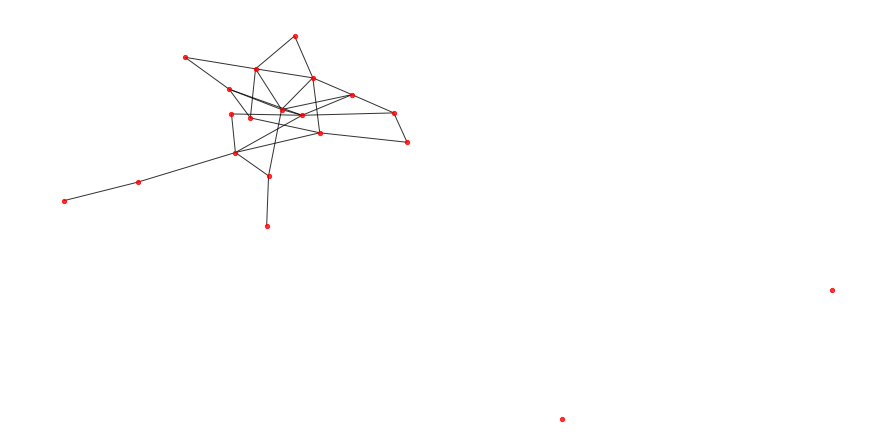

In [68]:
plt.figure(figsize=(12,6))
nx.draw(G,node_color='r', node_size=18, alpha=0.8)
plt.show()

In [69]:
#Vertex Cover Greedy Algorithm
visited = np.zeros(nodes)
cnt = 0
for e in edges:
    (u,v) = e
    if ((visited[u]==0) & (visited[v]==0)):
        visited[u] = 1
        visited[v] = 1
        cnt+=2

In [70]:
print("Vertex cover consists of {} nodes".format(cnt))

Vertex cover consists of 14 nodes


In [71]:
approximation_algo_result = cnt
approximation_algo_result

14

In [72]:
n = nodes
pop_total = int(50 * max(1, round(n / 5.0))) # max population allowed in the environment
pop_init = int(20 * max(1, round(n / 5.0)))
max_iterate = int(7 * max(1, round(n / 5.0)))

In [73]:
print("N = {}\nPopulation Total = {}\nPopulation Initial = {}\nMax Iteration = {}\n".format(n, pop_total, pop_init, max_iterate))

N = 20
Population Total = 200
Population Initial = 80
Max Iteration = 28



In [74]:
def chromosomes_gen(n,k,pop_init):
    lst = []
    for i in range(pop_init):
        chromosome = np.zeros(n,dtype= int)
        samples = random.sample(range(0,n), k = k)
        for j in range(k):
            chromosome[samples[j]] = 1
        lst.append(chromosome)
    return lst

In [75]:
def cost(cmbn,n,edges):
    obstacles = 0
    for e in edges:
        (u,v) = e
        if ((cmbn[u]==0) & (cmbn[v]==0)):
            obstacles += 1
    return obstacles

In [76]:
def selection(lst,pop_total,n,edges):
    score = []
    output_lst = []
    len_lst = len(lst)
    for i in range(len_lst):
        score.append(cost(lst[i],n,edges))
    sorted_index = np.argsort(score)
    cnt = 0
    for i in range(len_lst):
        output_lst.append(lst[sorted_index[i]])
        if((i+1) == pop_total):
            break
    lst = output_lst
    return lst,score[sorted_index[0]]

In [77]:
mutat_prob = 0.05
def cross_over_mutate_extended(lst,n,k,mutat_prob,pop_total,edges):
    new_lst = lst.copy()
    len_lst = len(lst)
    cross_over_prob = 0.50
    variations = 1
    
    #Crossover
    for i in range(len_lst):
        for v in range(variations):
            tmp = lst[i].copy()

            mate_with = lst[int(random.uniform(0,len_lst))]

            tmp_unique = []
            mate_with_unique = []

            for j in range(n):
                if(tmp[j]==1):
                    tmp_unique.append(j)
                if(mate_with[j]==1):
                    mate_with_unique.append(j)

            tmp_unique = np.setdiff1d(tmp,mate_with)
            random.shuffle(tmp_unique)
            mate_with_unique = np.setdiff1d(mate_with,tmp)
            random.shuffle(mate_with_unique)

            swap = math.ceil(cross_over_prob * min(len(tmp_unique),len(mate_with_unique)))

            for j in range(swap):
                tmp[mate_with_unique[j]] = 1
                tmp[tmp_unique[j]] = 0

            # Mutation 
            zeroes = []
            ones = []
            for j in range(n):
                if tmp[j]==1:
                    ones.append(j)
                else:
                    zeroes.append(j)
            
            random.shuffle(ones)
            random.shuffle(zeroes)

            coin_toss = random.random()
            if(coin_toss <= 0.5):
                swaps = min(len(ones),len(zeroes))

                for j in range(swaps):
                    coin_toss2 = random.random()
                    if(coin_toss2 < mutat_prob):
                        tmp[ones[j]] = 0
                        tmp[zeroes[j]] = 1
                        #Swapping logic
                        dummy = ones[j]
                        ones[j] = zeroes[j]
                        zeroes[j] = dummy
            else:    
                mutate_lst = []
                for e in edges:
                    (u,v) = e
                    if((tmp[u] == 0) & (tmp[v] == 0)):
                        coin_toss2 = random.random()
                        if(coin_toss2 < mutat_prob):
                            coin_toss3 = random.random()
                            if(coin_toss3 <= 0.5):
                                if(u not in mutate_lst):
                                    mutate_lst.append(u)
                            else:
                                if(v not in mutate_lst):
                                    mutate_lst.append(v)

                random.shuffle(mutate_lst)
                sz = min(len(ones),len(mutate_lst))
                
                for j in range(sz):
                    tmp[ones[j]] = 0
                    tmp[mutate_lst[j]] = 1
                    #Swapping logic
                    dummy = ones[j]
                    ones[j] = mutate_lst[j]
                    mutate_lst[j] = dummy
                
            new_lst.append(tmp)
    
    return new_lst

In [78]:
def environment(n,k,mutat_prob,pop_init,pop_total,max_iterate,edges):
    lst = chromosomes_gen(n,k,pop_init)
    for it in range(max_iterate):
        lst = cross_over_mutate_extended(lst,n,k,mutat_prob,pop_total,edges)
        lst,cost_value = selection(lst,pop_total,n,edges)
        if (it%10)==9:
            print("k = {}, Iteration = {}, Cost = {}".format(k,it+1,cost_value))
        if cost_value==0:
            break
    result = []
    soln = lst[0]
    for j in range(len(soln)):
        if(soln[j] == 1):
            result.append(j)
    print("k = {}, Iteration = {}, Cost = {}\nVertex Cover = {}".format(k,it,cost_value,result))
    return cost_value,result

In [79]:
def free_memory():
    gc.collect()

In [80]:
def mfind(n,mutat_prob,pop_init,pop_total,max_iterate,edges,start,end):
    result_dict = {}
    l = start
    h = end
    ans = 0
    while(l<=h):
        m = int((l+h)/2.0)
        cost_value,result = environment(n,m,mutat_prob,pop_init,pop_total,max_iterate,edges)
#         print("Cost is {} result is {}".format(cost_value,result))
        if(cost_value==0):
            result_dict[m] = result
            h = m-1
        else:
            l = m + 1
    return result_dict

#Exact Method Output

In [81]:
free_memory()
time_now = time()
print("Minimum size of a vertex cover = ", findMinCover(nodes, edges_cnt))
time_end = time()
print("Time Taken for exact method: {:.8f} s".format(time_end - time_now))

Minimum size of a vertex cover =  10
Time Taken for exact method: 13.30465508 s


#Non-Exact Method Output

In [82]:
time_now = time()
result = mfind(n, mutat_prob, pop_init, pop_total, max_iterate, edges, int(approximation_algo_result / 2), n)
time_end = time()

vertex_cover = list(result.keys())[-1]
print("Length of Vertex Cover = {}".format(vertex_cover))
print("Time Taken for non-exact method: {:.8f} s".format(time_end - time_now))

k = 13, Iteration = 0, Cost = 0
Vertex Cover = [0, 1, 3, 4, 6, 8, 9, 11, 12, 13, 14, 16, 17]
k = 9, Iteration = 10, Cost = 1
k = 9, Iteration = 20, Cost = 1
k = 9, Iteration = 27, Cost = 1
Vertex Cover = [1, 2, 3, 6, 8, 10, 13, 15, 17]
k = 11, Iteration = 6, Cost = 0
Vertex Cover = [2, 4, 5, 6, 8, 10, 11, 13, 14, 15, 17]
k = 10, Iteration = 10, Cost = 1
k = 10, Iteration = 11, Cost = 0
Vertex Cover = [2, 3, 4, 5, 6, 8, 10, 13, 15, 17]
Length of Vertex Cover = 10
Time Taken for non-exact method: 2.12447739 s


In [83]:
result.keys()

dict_keys([13, 11, 10])